# 04. PyTorch Custom Datasets

How get your own data into PyTorch

One of the ways to do so is vias: custom datasets

Book version: https://www.learnpytorch.io/04_pytorch_custom_datasets/
Git version : https://github.com/mrdbourke/pytorch-deep-learning

## 0. Import PyTorch and setting up device-agnostic code

In [198]:
import torch
from torch import nn

torch.__version__

'2.0.0+cu118'

In [199]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [200]:
!nvidia-smi

Fri Apr  7 21:51:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    29W /  70W |   2421MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1. Get some data

This part will be different, i'll use another data from original in the course

1. Try make recognize characters

In [201]:
from pathlib import Path

if Path("data/characters_data").is_dir():
  print(f"Files already exists.")
else:
  data_path = Path("data/")
  print(f"File does not exist, creating one")
  !mkdir '/content/data'

  try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    # Copiando a pasta
    !cp -r '/content/gdrive/MyDrive/characters_data' '/content/data/characters_data'
  except:
      # Código para executar se o Google Drive não puder ser montado
      print('Não foi possível montar o Google Drive')

image_path = Path("data/characters_data")

train_dir = image_path / 'train'
test_dir = image_path / 'test'
train_dir, test_dir

Files already exists.


(PosixPath('data/characters_data/train'),
 PosixPath('data/characters_data/test'))

In [202]:
#!rm -r '/content/data/characters_data/test/levi'
#!rm -r '/content/data/characters_data/test/beel'
#!rm -r '/content/data/characters_data/train/levi'
#!rm -r '/content/data/characters_data/train/beel'

## 2. Becoming one with the data (data preparation and data exploration)


In [203]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/characters_data'.
There are 6 directories and 0 images in 'data/characters_data/train'.
There are 0 directories and 59 images in 'data/characters_data/train/Asmo'.
There are 0 directories and 59 images in 'data/characters_data/train/Satan'.
There are 0 directories and 59 images in 'data/characters_data/train/Leviathan'.
There are 0 directories and 59 images in 'data/characters_data/train/Mammon'.
There are 0 directories and 59 images in 'data/characters_data/train/Lucifer'.
There are 0 directories and 59 images in 'data/characters_data/train/Beel'.
There are 6 directories and 0 images in 'data/characters_data/test'.
There are 0 directories and 10 images in 'data/characters_data/test/Asmo'.
There are 0 directories and 10 images in 'data/characters_data/test/Satan'.
There are 0 directories and 10 images in 'data/characters_data/test/Leviathan'.
There are 0 directories and 10 images in 'data/characters_data/test/Mammon'.
There are 0 directorie

## 2.1 Visualizing an image

1. Get all the image paths
2. Pick a random image path using python's random.choice()
3. Get image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. Show image and print metadata

Total length: 414 
Length of train image: 354 
Length of test image: 60
First three images: [PosixPath('data/characters_data/train/Asmo/RAD_(Lust).webp'), PosixPath('data/characters_data/train/Asmo/I_Am_Your_Present!.webp'), PosixPath('data/characters_data/train/Asmo/The_King_of_the_Party_(Lust).webp')]
Random image path: data/characters_data/train/Beel/Beelzebub_the_Roadie.webp
Image class: Beel
Image height and width: 256 x 256


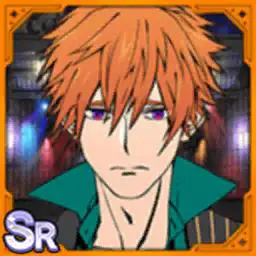

In [204]:
import random
from PIL import Image
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.webp"))
image_train_list = list(image_path.glob("train/*/*.webp"))
image_test_list = list(image_path.glob("test/*/*.webp"))
print(f"Total length: {len(image_path_list)} \nLength of train image: {len(image_train_list)} \nLength of test image: {len(image_test_list)}")
print(f"First three images: {image_path_list[:3]}")

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height and width: {img.height} x {img.width}")
img

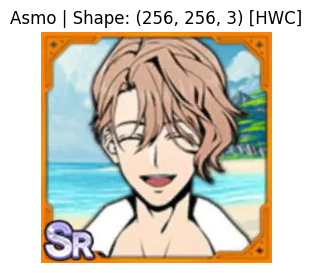

In [205]:
import matplotlib.pyplot as plt
import numpy as np

random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

# turn image -> array
img_as_array = np.array(img)

plt.figure(figsize=(3,3))
plt.imshow(img_as_array)
plt.title(f"{image_class} | Shape: {img_as_array.shape} [HWC]")
plt.axis(False);

In [206]:
#img_as_array

## 3. Transforming data

1. TURN YOUR TARGET DATA INTO TENSORS 
2. turn into a `torch.utils.data.Dataset` and subquently a `torch.utils.data.DataLoader`

In [207]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## 3.1 Transforming data with `torchvision.tranforms`

In [208]:
# Define as transformações de pré-processamento das imagens
data_transform = transforms.Compose([
    #resize images
    transforms.Resize(256), 
    # flip images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), 
  #  transforms.CenterCrop(224)), 
    # Turn the image to tensor
    transforms.ToTensor(),
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    
])

data_transform(img).shape

torch.Size([3, 256, 256])

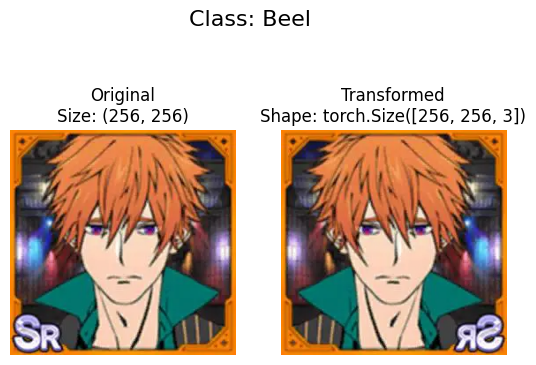

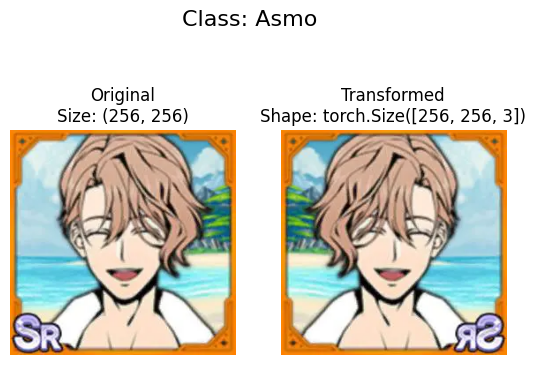

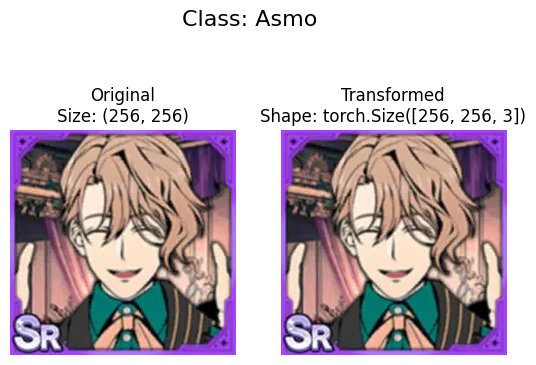

In [209]:
def plot_transformed_images(image_paths, transform, n = 2, seed=42):
  """"
  Selects random images from a path of images and loads/transforms them 
  then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k = n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)
      
      transformed_image = transform(f).permute(1,2,0) #note we will need to change shape for matplotlib
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading image data using `Image Folder`

In [210]:
# Carrega os dados de treinamento
train_data = datasets.ImageFolder(train_dir, 
                                  transform= transforms.ToTensor(),
                                  target_transform=None)

# Carrega os dados de teste
test_data = datasets.ImageFolder(test_dir, 
                                 transform= transforms.ToTensor(),
                                 target_transform=None)

In [211]:
len(train_data), len(test_data)

(354, 60)

In [212]:
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 354
     Root location: data/characters_data/train
     StandardTransform
 Transform: ToTensor(),
 Dataset ImageFolder
     Number of datapoints: 60
     Root location: data/characters_data/test
     StandardTransform
 Transform: ToTensor())

In [213]:
train_data.classes

['Asmo', 'Beel', 'Leviathan', 'Lucifer', 'Mammon', 'Satan']

In [214]:
class_names = train_data.classes
class_names

['Asmo', 'Beel', 'Leviathan', 'Lucifer', 'Mammon', 'Satan']

In [215]:
class_dict = train_data.class_to_idx
class_dict

{'Asmo': 0, 'Beel': 1, 'Leviathan': 2, 'Lucifer': 3, 'Mammon': 4, 'Satan': 5}

In [216]:
train_data.samples[:2]

[('data/characters_data/train/Asmo/A_Pillow_for_the_Gram.webp', 0),
 ('data/characters_data/train/Asmo/All_Mine.webp', 0)]

In [217]:
train_data[0]

(tensor([[[0.9333, 0.9490, 0.9647,  ..., 0.9490, 0.9373, 0.9294],
          [0.9490, 0.9608, 0.9725,  ..., 0.9569, 0.9451, 0.9451],
          [0.9804, 0.9843, 0.9961,  ..., 0.9647, 0.9608, 0.9608],
          ...,
          [0.9412, 0.9373, 0.9490,  ..., 0.9569, 0.9686, 0.9686],
          [0.9843, 0.9725, 0.9725,  ..., 0.9216, 0.9137, 0.9137],
          [1.0000, 0.9922, 0.9922,  ..., 0.9020, 0.8902, 0.8824]],
 
         [[0.0314, 0.0235, 0.0118,  ..., 0.0078, 0.0118, 0.0157],
          [0.0235, 0.0157, 0.0078,  ..., 0.0039, 0.0078, 0.0078],
          [0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0157, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0235, 0.0235],
          [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0353, 0.0392]],
 
         [[0.0000, 0.0000, 0.0039,  ..., 0.0392, 0.0392, 0.0392],
          [0.0000, 0.0000, 0.0039,  ..., 0.0392, 0.0392, 0.0392],
          [0.0000, 0.0000, 0.0039,  ...,

In [218]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.9333, 0.9490, 0.9647,  ..., 0.9490, 0.9373, 0.9294],
         [0.9490, 0.9608, 0.9725,  ..., 0.9569, 0.9451, 0.9451],
         [0.9804, 0.9843, 0.9961,  ..., 0.9647, 0.9608, 0.9608],
         ...,
         [0.9412, 0.9373, 0.9490,  ..., 0.9569, 0.9686, 0.9686],
         [0.9843, 0.9725, 0.9725,  ..., 0.9216, 0.9137, 0.9137],
         [1.0000, 0.9922, 0.9922,  ..., 0.9020, 0.8902, 0.8824]],

        [[0.0314, 0.0235, 0.0118,  ..., 0.0078, 0.0118, 0.0157],
         [0.0235, 0.0157, 0.0078,  ..., 0.0039, 0.0078, 0.0078],
         [0.0078, 0.0039, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0157, 0.0118, 0.0118,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0235, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0314, 0.0353, 0.0392]],

        [[0.0000, 0.0000, 0.0039,  ..., 0.0392, 0.0392, 0.0392],
         [0.0000, 0.0000, 0.0039,  ..., 0.0392, 0.0392, 0.0392],
         [0.0000, 0.0000, 0.0039,  ..., 0.03

Original shape: torch.Size([3, 256, 256])
Image permute: torch.Size([256, 256, 3])


(-0.5, 255.5, 255.5, -0.5)

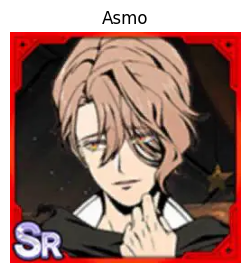

In [219]:
# Rearrange the order dimensions
img_permute = img.permute(1,2,0)

print(f"Original shape: {img.shape}")
print(f"Image permute: {img_permute.shape}")

plt.figure(figsize=(3,3))
plt.imshow(img_permute)
plt.title(f"{class_names[label]}")
plt.axis(False)

### 4.1 Turn loaded images into `Dataloader's`

In [220]:
import os
os.cpu_count()

2

In [221]:
# Create a train and test dataset
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f12cb06b190>,
 <torch.utils.data.dataloader.DataLoader at 0x7f12cb06b100>)

In [222]:
len(train_dataloader), len(test_dataloader)

(354, 60)

In [223]:
img, label = next(iter(train_dataloader))
print(f"Image shape {img.shape} [BATCH_SIZE, color_channel, height, width]")
print(f"Label shape {label.shape}")

Image shape torch.Size([1, 3, 256, 256]) [BATCH_SIZE, color_channel, height, width]
Label shape torch.Size([1])


## 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many 
2. To prevent the display getting out of hand, cap the number of images to see a little
3. Set the random seed for reproducibility
4. Get a list of random samples indexes from the target dataset
5. Setup a matplotlib plot
6. Loop through the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib(HWC)


In [224]:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: list[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shoudn't be larger than 10, setting to 10 and removing display")

  #Set the random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  # 5. Setup plot out the loop
  plt.figure(figsize= (18,8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1,2,0)

    #Plot adjust examples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nShape {targ_image_adjust.shape}"
    plt.title(title)


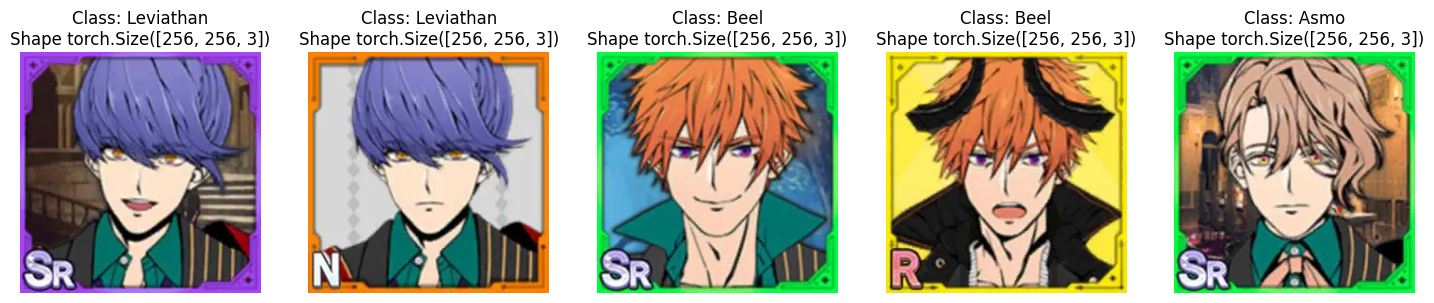

In [225]:
# Display from ImageFolder created dataset
display_random_images(dataset = train_data, 
                      n = 5,
                      classes = class_names,
                      seed = None)

## 6. Other forms of transforms ( data argumentation)

Data argumentation is the process of artificially adding diversity to your trainig data
In other words, is applying various image transformations to the training images

In [226]:
from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                       transforms.ToTensor()])
test_tranform = transforms.Compose([transforms.Resize(size=(224,224)),
                                       transforms.ToTensor()])

In [227]:
# Get all images paths
image_path_list = list(image_path.glob("*/*/*.webp"))
image_path_list[:10]

[PosixPath('data/characters_data/train/Asmo/RAD_(Lust).webp'),
 PosixPath('data/characters_data/train/Asmo/I_Am_Your_Present!.webp'),
 PosixPath('data/characters_data/train/Asmo/The_King_of_the_Party_(Lust).webp'),
 PosixPath('data/characters_data/train/Asmo/The_Bathroom_of_Desire_(Pride).webp'),
 PosixPath('data/characters_data/train/Asmo/Wander_into_My_Arms.webp'),
 PosixPath('data/characters_data/train/Asmo/Warm_Hug.webp'),
 PosixPath('data/characters_data/train/Asmo/The_Bathroom_of_Desire_(Greed).webp'),
 PosixPath('data/characters_data/train/Asmo/The_Butler_s_Secret.webp'),
 PosixPath('data/characters_data/train/Asmo/I_m_So_Pretty.webp'),
 PosixPath('data/characters_data/train/Asmo/The_Living_Room_(Gluttony).webp')]

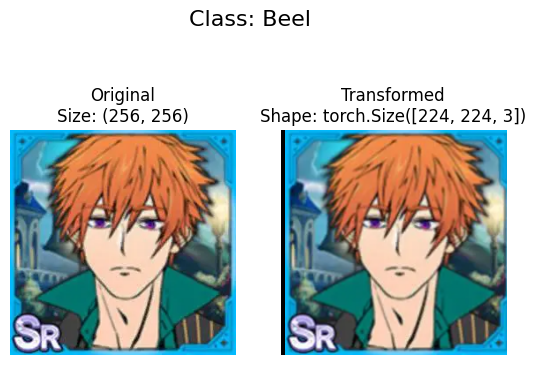

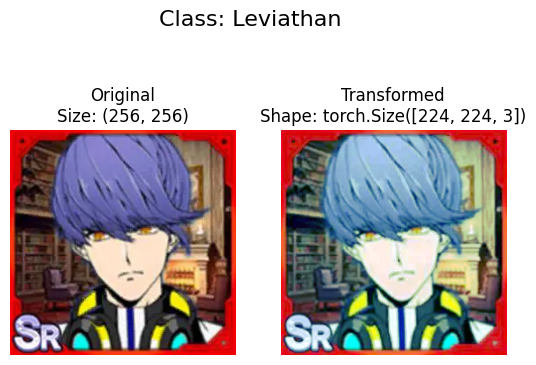

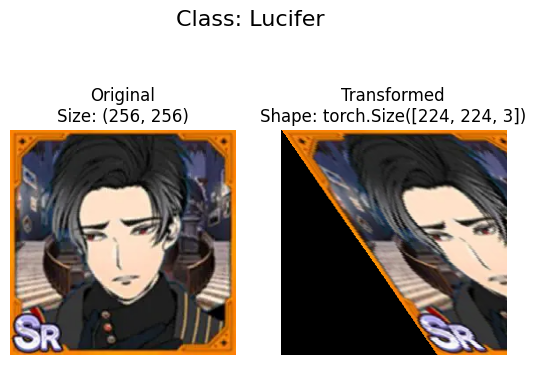

In [228]:
plot_transformed_images(image_paths = image_path_list,
                        transform = train_transform,
                        n = 3,
                        seed = None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for model 0

In [229]:
from pathlib import Path

# caminhos dos dados
image_path = Path("/content/data/characters_data")
train_path = image_path / 'train'
test_path = image_path / 'test'

#Simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (100,100)),
    transforms.CenterCrop(size=(90,90)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()])

# train and test datasets
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_path,
                                  transform = simple_transform)
test_data = datasets.ImageFolder(root = test_path,
                                 transform = simple_transform)

# train and test dataloader
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers=NUM_WORKERS)
test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

In [230]:
class_dict = train_data.class_to_idx
class_names = train_data.classes

(-0.5, 89.5, 89.5, -0.5)

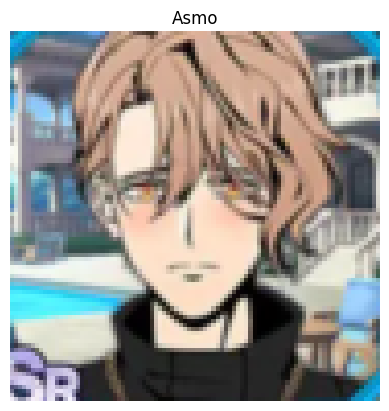

In [231]:
plt.imshow(train_data[7][0].permute(1,2,0))
plt.title(class_names[train_data[9][1]])
plt.axis(False)

In [232]:
from torch import nn
class TinyVGGModel(nn.Module):
  def __init__(self, 
               input_shape: int,
               hidden_units:int,
               output_shape:int):
    super().__init__(),
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*22*22, 
                  out_features=output_shape)
    )
  
  def forward(self, x):
    x = self.block_1(x)
    #print(x.shape)
    x = self.block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x


In [233]:
torch.manual_seed(42)
model_0 = TinyVGGModel(input_shape = 3,
                       hidden_units = 64,
                       output_shape = len(class_names))
model_0.to(device)
model_0

TinyVGGModel(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=30976, out_features=6, bias=True)
  )
)

# 7.3 Testing model with forward pass

In [234]:
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 90, 90]), torch.Size([32]))

In [235]:
y_logit = model_0(image_batch.to(device))
y_logit

tensor([[-3.1268e-03, -5.9353e-03,  3.6149e-03, -8.4764e-03, -6.0726e-03,
          1.4658e-02],
        [-7.3059e-03,  9.1095e-04,  4.5754e-03, -8.9856e-03, -3.8151e-03,
          1.5985e-02],
        [-1.0448e-02, -3.6273e-03,  5.8320e-03, -1.0088e-02, -3.1909e-03,
          2.0511e-02],
        [-1.0678e-02, -5.8059e-03,  4.5366e-03, -1.1687e-02, -6.5170e-03,
          1.8762e-02],
        [-8.2808e-03, -2.6310e-03,  2.2056e-03, -9.0194e-03, -3.5378e-03,
          2.0222e-02],
        [-6.8473e-03, -4.4788e-03,  4.9979e-03, -9.2064e-03, -1.9725e-03,
          2.1923e-02],
        [-5.6459e-03, -3.9913e-03,  1.7613e-03, -5.6588e-03, -6.6866e-03,
          1.9503e-02],
        [-6.6164e-03,  5.0002e-04,  4.5737e-03, -8.4042e-03, -4.1070e-03,
          1.6313e-02],
        [-9.5998e-03,  1.4534e-03,  4.8127e-03, -1.6386e-02, -6.7766e-03,
          1.3214e-02],
        [ 1.4774e-03,  2.1341e-03,  7.3104e-03, -6.1372e-03, -4.0130e-03,
          1.9516e-02],
        [-5.4981e-03,  2.8857e

In [236]:
y_pred = y_logit.argmax(dim=1)
y_pred

tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5], device='cuda:0')

In [237]:
y_prob = torch.softmax(y_logit, dim=1)
y_prob

tensor([[0.1663, 0.1658, 0.1674, 0.1654, 0.1658, 0.1693],
        [0.1654, 0.1668, 0.1674, 0.1651, 0.1660, 0.1693],
        [0.1650, 0.1661, 0.1677, 0.1650, 0.1662, 0.1701],
        [0.1652, 0.1660, 0.1677, 0.1650, 0.1659, 0.1701],
        [0.1653, 0.1662, 0.1671, 0.1652, 0.1661, 0.1701],
        [0.1654, 0.1658, 0.1674, 0.1650, 0.1662, 0.1702],
        [0.1657, 0.1660, 0.1670, 0.1657, 0.1656, 0.1700],
        [0.1655, 0.1667, 0.1674, 0.1652, 0.1659, 0.1693],
        [0.1654, 0.1673, 0.1678, 0.1643, 0.1659, 0.1692],
        [0.1663, 0.1665, 0.1673, 0.1651, 0.1654, 0.1694],
        [0.1655, 0.1669, 0.1677, 0.1646, 0.1659, 0.1694],
        [0.1648, 0.1667, 0.1675, 0.1655, 0.1657, 0.1698],
        [0.1656, 0.1673, 0.1673, 0.1646, 0.1657, 0.1696],
        [0.1655, 0.1663, 0.1672, 0.1651, 0.1658, 0.1701],
        [0.1657, 0.1659, 0.1678, 0.1652, 0.1654, 0.1700],
        [0.1659, 0.1659, 0.1669, 0.1654, 0.1659, 0.1700],
        [0.1649, 0.1668, 0.1663, 0.1651, 0.1670, 0.1699],
        [0.165

In [238]:
plt.imshow(image_batch[0].permute(1,2,0))

In [239]:
!pip install torchinfo
import torchinfo
from torchinfo import summary
summary(model_0, input_size=(BATCH_SIZE, 3, 90, 90))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModel                             [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 45, 45]          --
│    └─Conv2d: 2-1                       [32, 64, 90, 90]          1,792
│    └─ReLU: 2-2                         [32, 64, 90, 90]          --
│    └─Conv2d: 2-3                       [32, 64, 90, 90]          36,928
│    └─ReLU: 2-4                         [32, 64, 90, 90]          --
│    └─MaxPool2d: 2-5                    [32, 64, 45, 45]          --
├─Sequential: 1-2                        [32, 64, 22, 22]          --
│    └─Conv2d: 2-6                       [32, 64, 45, 45]          36,928
│    └─ReLU: 2-7                         [32, 64, 45, 45]          --
│    └─Conv2d: 2-8                       [32, 64, 45, 45]          36,928
│    └─ReLU: 2-9                         [32, 64, 45, 45]          --
│    └─MaxPool2d: 2-10                   [32, 64, 22, 22]          --


In [240]:
## 8.

In [241]:
# Setup optimizer, loss and evalution metrics

In [242]:
# Picking accuracy from helper_functions of git
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [243]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr = 0.01)

In [244]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  
  train_loss = 0
  model.train()
  
  for batch, (X, y) in enumerate(dataloader):
    X,y = X.to(device), y.to(device)
    
    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  #print(f"Y_pred : {y_pred}")
  print(f"Y_pred : {y_pred.argmax(dim=1)}")
  print(f"Truth: {y}")
    
  return train_loss

def test_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device = device):
  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y = X.to(device), y.to(device)
      
      test_pred = model(X)

      test_loss += loss_fn(test_pred, y).item()
     
    print(f"Test_pred: {test_pred.argmax(dim=1)}")
    print(f"Truth: {y}")
      
    return test_loss

In [245]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 20

for epoch in range(epochs):
  print(f"Epoch: {epoch} ----------")
  train_loss = train_step(model_0,
                          train_dataloader,
                          loss_fn,
                          optimizer)
  
  test_loss = test_step(model_0,
                        test_dataloader,
                        loss_fn)

  print(f"Train loss: {train_loss/BATCH_SIZE},Test loss: {test_loss/BATCH_SIZE}\n")

Epoch: 0 ----------
Y_pred : tensor([5, 5], device='cuda:0')
Truth: tensor([1, 2], device='cuda:0')
Test_pred: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1], device='cuda:0')
Truth: tensor([1, 1, 5, 4, 4, 2, 1, 1, 3, 3, 4, 5, 0, 1, 4, 3, 1, 0, 4, 3, 2, 2, 4, 2,
        1, 4, 0, 2], device='cuda:0')
Train loss: 0.6710348576307297,Test loss: 0.11139319837093353

Epoch: 1 ----------
Y_pred : tensor([1, 1], device='cuda:0')
Truth: tensor([4, 2], device='cuda:0')
Test_pred: tensor([2, 2, 4, 4, 4, 2, 2, 4, 4, 2, 4, 2, 4, 2, 2, 2, 4, 4, 4, 4, 2, 4, 4, 4,
        4, 2, 4, 4], device='cuda:0')
Truth: tensor([1, 2, 1, 4, 4, 3, 1, 0, 5, 3, 4, 2, 0, 3, 3, 3, 4, 0, 4, 1, 2, 0, 5, 4,
        1, 3, 5, 5], device='cuda:0')
Train loss: 0.6658169738948345,Test loss: 0.1103905588388443

Epoch: 2 ----------
Y_pred : tensor([2, 1], device='cuda:0')
Truth: tensor([2, 1], device='cuda:0')
Test_pred: tensor([1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 

In [246]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.eval()
  
  with torch.inference_mode():
    for sample in data:

      sample = sample.unsqueeze(dim = 0).to(device)

      pred_logit = model(sample)

      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)

      pred_probs.append(pred_prob.to(device))

    return torch.stack(pred_probs)


In [247]:
import random 
#random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)
test_samples[0].shape, test_labels

(torch.Size([3, 90, 90]), [0, 3, 2, 0, 0, 5, 1, 1, 3])

In [248]:
pred_probs = make_predictions(model = model_0,
                              data = test_samples)

pred_probs

tensor([[9.8398e-01, 1.1480e-05, 3.2085e-03, 2.3865e-03, 6.7817e-03, 3.6336e-03],
        [1.0367e-04, 2.0072e-06, 1.1818e-04, 9.9975e-01, 3.3210e-06, 2.5501e-05],
        [3.0480e-02, 1.5699e-04, 9.6386e-01, 2.1777e-04, 4.7746e-03, 5.1106e-04],
        [9.8618e-01, 4.1348e-03, 7.3387e-03, 1.9294e-04, 7.4116e-04, 1.4149e-03],
        [7.4628e-01, 1.1679e-03, 1.6126e-02, 3.4754e-03, 7.4690e-02, 1.5826e-01],
        [3.7759e-03, 5.0512e-04, 2.2761e-05, 8.6219e-04, 8.0018e-04, 9.9403e-01],
        [1.8879e-03, 9.8572e-01, 5.4648e-05, 2.0491e-04, 1.6460e-06, 1.2128e-02],
        [2.3200e-04, 9.9816e-01, 6.1710e-05, 1.6279e-05, 5.8467e-08, 1.5251e-03],
        [5.5806e-04, 8.9660e-07, 1.3482e-04, 9.9926e-01, 2.9207e-06, 3.8394e-05]],
       device='cuda:0')

In [249]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 3, 2, 0, 0, 5, 1, 1, 3], device='cuda:0')

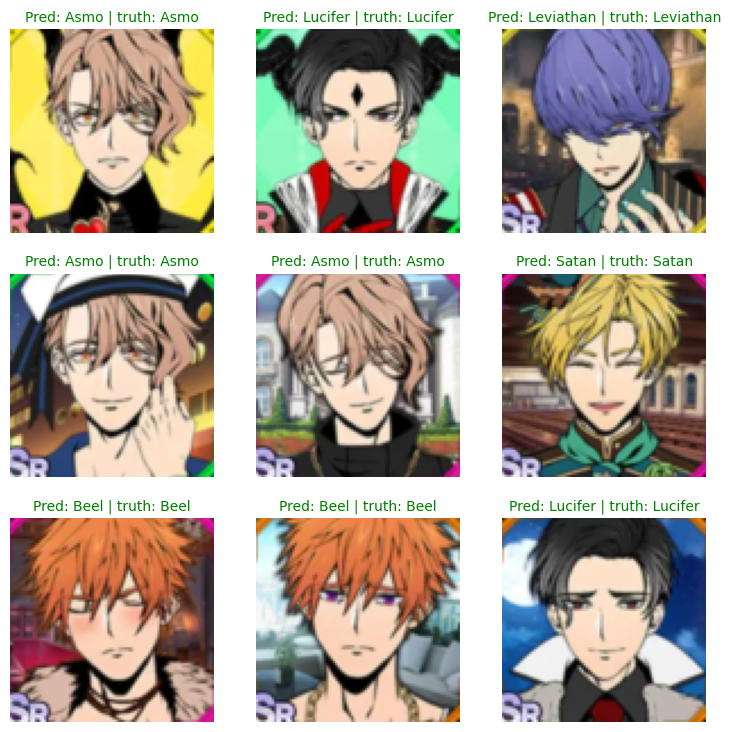

In [250]:
plt.figure(figsize = (9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot 
  plt.subplot(nrows, ncols, i+1)

  # plot the target image
  plt.imshow(sample.permute(1,2,0))
  
  # find the prediction (in text form, e.g "Sandal")
  pred_label = class_names[pred_classes[i]]
  
  # get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | truth: {truth_label}"

  # Check for equality between pred and truth and change color of title
  if pred_label == truth_label:
    plt.title(title_text, fontsize= 10, c = "g")
  else:
    plt.title(title_text, fontsize= 10, c = "r")
  plt.axis(False)

In [251]:
summary(model_0, input_size=(BATCH_SIZE, 3, 90, 90))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGModel                             [32, 6]                   --
├─Sequential: 1-1                        [32, 64, 45, 45]          --
│    └─Conv2d: 2-1                       [32, 64, 90, 90]          1,792
│    └─ReLU: 2-2                         [32, 64, 90, 90]          --
│    └─Conv2d: 2-3                       [32, 64, 90, 90]          36,928
│    └─ReLU: 2-4                         [32, 64, 90, 90]          --
│    └─MaxPool2d: 2-5                    [32, 64, 45, 45]          --
├─Sequential: 1-2                        [32, 64, 22, 22]          --
│    └─Conv2d: 2-6                       [32, 64, 45, 45]          36,928
│    └─ReLU: 2-7                         [32, 64, 45, 45]          --
│    └─Conv2d: 2-8                       [32, 64, 45, 45]          36,928
│    └─ReLU: 2-9                         [32, 64, 45, 45]          --
│    └─MaxPool2d: 2-10                   [32, 64, 22, 22]          --


In [252]:
from keras.models import Model

image_test_batch, label_test_batch = next(iter(test_dataloader))
image_test_batch = image_test_batch.to(device)
# Suponha que `model` é o seu modelo original

intermediate_output_1 = model_0._modules.get('block_1')(image_test_batch[0])
intermediate_output_2 = model_0._modules.get('block_2')(intermediate_output_1)
input_features = 30976 # number of input features of the first linear layer in the classifier
intermediate_output_2_1 = intermediate_output_2.view(input_features).unsqueeze(dim=0)
intermediate_output_3 = model_0._modules.get('classifier')(intermediate_output_2_1)

In [253]:
intermediate_output_1.shape, intermediate_output_2.shape, intermediate_output_3.shape

(torch.Size([64, 45, 45]), torch.Size([64, 22, 22]), torch.Size([1, 6]))

In [254]:
# NumPy only supports arrays stored on the CPU.7
intermediate_output_1 = intermediate_output_1.cpu().detach().numpy()

In [255]:
import matplotlib.pyplot as plt

# Suponha que `intermediate_output` é o array contendo as ativações
# da camada intermediária que você deseja visualizar
n = intermediate_output_1.shape[-1] # número de ativações

plt.figure(figsize=(20, 20))
for i in range(n):
    plt.subplot(n // 8 + 1, 8, i + 1)
    plt.imshow(intermediate_output_1[:, :, i])
    plt.axis('off')
plt.show()

In [256]:
intermediate_output_2 = intermediate_output_2.cpu().detach().numpy()

In [257]:
# Suponha que `intermediate_output` é o array contendo as ativações
# da camada intermediária que você deseja visualizar
n = intermediate_output_2.shape[-1] # número de ativações

plt.figure(figsize=(20, 20))
for i in range(n):
    plt.subplot(n // 8 + 1, 8, i + 1)
    plt.imshow(intermediate_output_2[:, :, i], cmap = "gray")
    plt.axis('off')
plt.show()

In [258]:
intermediate_output_3, intermediate_output_3.argmax()

(tensor([[ 1.3905, -5.0431, -0.0299,  8.8809, -3.8621, -1.2860]],
        device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor(3, device='cuda:0'))

In [259]:
label_test_batch

tensor([3, 4, 1, 0, 3, 4, 1, 5, 0, 5, 0, 0, 3, 5, 4, 0, 2, 2, 3, 0, 1, 1, 1, 1,
        4, 3, 2, 2, 5, 3, 0, 4])

In [260]:
image_test_batch = image_test_batch[0].permute(1,2,0).cpu().detach().numpy()

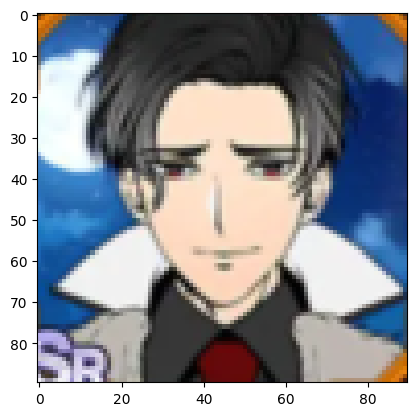

In [261]:
plt.imshow(image_test_batch)

In [311]:
extra_img_path = Path('/content/Levi_Villain_Struggles.webp')
extra_img = Image.open(extra_img_path)
extra_img


In [312]:
basic_transforms = transforms.Compose([transforms.Resize(size = (100,100)), 
                                       transforms.CenterCrop(size = (90,90)),
                                       transforms.ToTensor()])

extra_img_test = basic_transforms(extra_img)
extra_img_test

tensor([[[0.2314, 0.3137, 0.2510,  ..., 0.1843, 0.2275, 0.1922],
         [0.3216, 0.4118, 0.2902,  ..., 0.1686, 0.3608, 0.2510],
         [0.2706, 0.2902, 0.2078,  ..., 0.1137, 0.2510, 0.2431],
         ...,
         [0.5569, 0.1804, 0.2196,  ..., 0.0706, 0.0549, 0.0549],
         [0.8667, 0.3804, 0.1922,  ..., 0.0627, 0.1412, 0.0863],
         [0.9765, 0.8706, 0.6941,  ..., 0.0863, 0.1176, 0.1137]],

        [[0.6588, 0.5333, 0.6235,  ..., 0.6471, 0.4902, 0.5804],
         [0.5059, 0.4157, 0.5098,  ..., 0.5686, 0.4157, 0.4353],
         [0.5882, 0.4941, 0.6314,  ..., 0.6941, 0.5216, 0.5608],
         ...,
         [0.4706, 0.1412, 0.2745,  ..., 0.7412, 0.5451, 0.5882],
         [0.7608, 0.3020, 0.2157,  ..., 0.5843, 0.3020, 0.3569],
         [0.8941, 0.7765, 0.6078,  ..., 0.5882, 0.3765, 0.4667]],

        [[0.2627, 0.2471, 0.2667,  ..., 0.2902, 0.2392, 0.2235],
         [0.2353, 0.2235, 0.2275,  ..., 0.2471, 0.2588, 0.2000],
         [0.2353, 0.1882, 0.2431,  ..., 0.2549, 0.2118, 0.

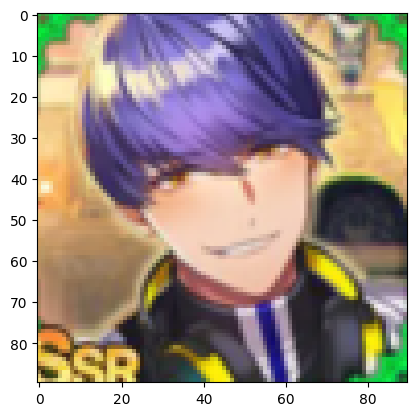

In [313]:
plt.imshow(extra_img_test.permute(1,2,0))

In [314]:
model_0.eval()
with torch.inference_mode():
  y_pred = model_0(extra_img_test.to(device).unsqueeze(dim=0))


In [315]:
y_pred

tensor([[ 2.2140, -5.2335,  3.9270, -1.9285,  1.3063, -0.3549]],
       device='cuda:0')

In [316]:
class_names[y_pred.argmax()]

'Leviathan'